In [1]:
!mkdir -p ./data/celeba
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip -O ./data/celeba/celeba.zip
!unzip -q ./data/celeba/celeba.zip -d ./data/celeba/


--2025-10-10 03:14:43--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.220.48, 52.219.117.168, 52.219.220.224, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.220.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘./data/celeba/celeba.zip’

./data/celeba/celeb 100%[===================>]   1.34G  76.1MB/s    in 22s     

2025-10-10 03:15:06 (61.4 MB/s) - ‘./data/celeba/celeba.zip’ saved [1443490838/1443490838]



In [2]:
!mkdir -p ./data/celeba/img_align_celeba/all
!mv ./data/celeba/img_align_celeba/*.jpg ./data/celeba/img_align_celeba/all/


/bin/bash: line 1: /usr/bin/mv: Argument list too long


🚀 Using device: cuda
✅ Clean dataset subset loaded: 8000 train, 2000 val
Epoch 1/10 - Train Loss: 0.023366 - Val Loss: 0.007810
Epoch 2/10 - Train Loss: 0.006212 - Val Loss: 0.004392
Epoch 3/10 - Train Loss: 0.004067 - Val Loss: 0.003462
Epoch 4/10 - Train Loss: 0.003473 - Val Loss: 0.002901
Epoch 5/10 - Train Loss: 0.002997 - Val Loss: 0.002731
Epoch 6/10 - Train Loss: 0.002704 - Val Loss: 0.003259
Epoch 7/10 - Train Loss: 0.002425 - Val Loss: 0.002167
Epoch 8/10 - Train Loss: 0.002562 - Val Loss: 0.002068
Epoch 9/10 - Train Loss: 0.002019 - Val Loss: 0.001893
Epoch 10/10 - Train Loss: 0.001752 - Val Loss: 0.001587


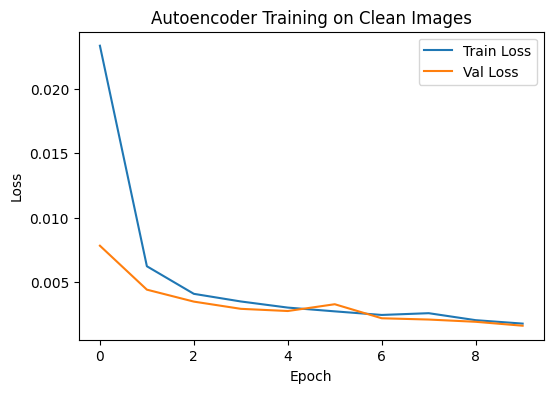

✅ Autoencoder trained and saved


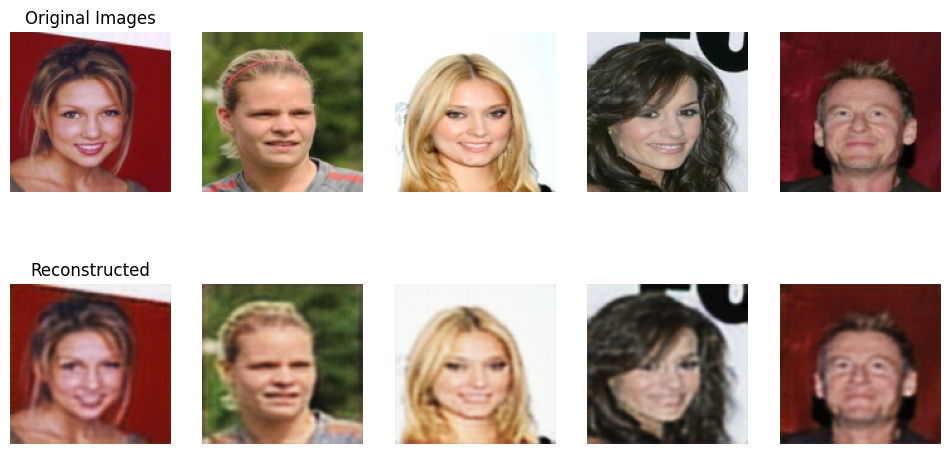

In [3]:
# ✅ Invisible Watermark Detection (Fast Training + Testing on Clean Images)
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
import torchvision.transforms as T
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

# -----------------------------
# Dataset: Clean CelebA (Fast subset)
# -----------------------------
class CelebADataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

transform = T.Compose([
    T.Resize((128,128)),  # can reduce to 64 for faster training
    T.ToTensor()
])

clean_dir = "./data/celeba/img_align_celeba"
dataset = CelebADataset(clean_dir, transform=transform)

# Use only a subset for fast training
subset_size = 10000  # 10k images
subset_indices = random.sample(range(len(dataset)), subset_size)
dataset = Subset(dataset, subset_indices)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Clean dataset subset loaded: {len(train_set)} train, {len(val_set)} val")

# -----------------------------
# Autoencoder
# -----------------------------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,stride=2,padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AutoEncoder().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# -----------------------------
# Training Loop + Testing on clean images
# -----------------------------
EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # ----- Training -----
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        opt.zero_grad()
        recon = model(imgs)
        loss = loss_fn(recon, imgs)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ----- Validation -----
    model.eval()
    val_loss_total = 0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            recon = model(imgs)
            loss = loss_fn(recon, imgs)
            val_loss_total += loss.item()
    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

# Plot training + validation loss
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder Training on Clean Images")
plt.legend()
plt.show()

# -----------------------------
# Save model
# -----------------------------
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/autoencoder_clean_fast.pth")
print("✅ Autoencoder trained and saved")

# -----------------------------
# Testing: visualize reconstruction on validation images
# -----------------------------
model.eval()
sample_imgs, _ = next(iter(val_loader))
sample_imgs = sample_imgs.to(device)
with torch.no_grad():
    recon_imgs = model(sample_imgs)

# Convert tensors to images and plot
sample_imgs = sample_imgs.cpu().permute(0,2,3,1).numpy()
recon_imgs = recon_imgs.cpu().permute(0,2,3,1).numpy()

plt.figure(figsize=(12,6))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
    if i==0: plt.title("Original Images")

    # Reconstructed
    plt.subplot(2,5,i+6)
    plt.imshow(recon_imgs[i])
    plt.axis('off')
    if i==0: plt.title("Reconstructed")
plt.show()


✅ Model loaded successfully on cuda

🔧 Calculating clean validation losses for threshold...
📊 Mean MSE (clean): 0.001792
📊 Std Deviation:   0.000683
⚙️ Auto Threshold:   0.003157

📤 Please upload an image from your device for watermark detection:


Saving clean.jpg to clean (1).jpg
✅ File uploaded: clean (1).jpg

Reconstruction MSE: 0.001147
Prediction: ✅ Clean


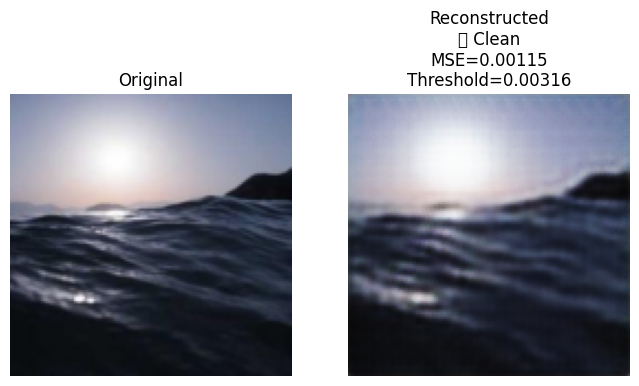

In [ ]:
# ==========================================================
# 🔍 Invisible Watermark Detection (Colab + Auto Threshold)
# ==========================================================
import torch, torch.nn as nn, torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import os, random, numpy as np, matplotlib.pyplot as plt
from google.colab import files

# -----------------------------
# Autoencoder (same as training)
# -----------------------------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,stride=2,padding=1), nn.Sigmoid()d
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# -----------------------------
# Dataset class (clean CelebA subset)
# -----------------------------
class CelebADataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

# -----------------------------
# Device + Model Load
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
model.load_state_dict(torch.load("models/autoencoder_clean_fast.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully on", device)

# -----------------------------
# Transforms
# -----------------------------
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

# -----------------------------
# Compute automatic threshold from clean validation subset
# -----------------------------
clean_dir = "./data/celeba/img_align_celeba"  # same clean folder used in training
dataset = CelebADataset(clean_dir, transform=transform)

subset_indices = random.sample(range(len(dataset)), min(300, len(dataset)))
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=16, shuffle=False)

print("\n🔧 Calculating clean validation losses for threshold...")
losses = []
with torch.no_grad():
    for imgs, _ in loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        mse_batch = torch.mean((recon - imgs) ** 2, dim=[1,2,3]).cpu().numpy()
        losses.extend(mse_batch)

losses = np.array(losses)
mean_loss = np.mean(losses)
std_loss = np.std(losses)
threshold = mean_loss + 2 * std_loss

print(f"📊 Mean MSE (clean): {mean_loss:.6f}")
print(f"📊 Std Deviation:   {std_loss:.6f}")
print(f"⚙️ Auto Threshold:   {threshold:.6f}")

# -----------------------------
# Upload image from device (Colab)
# -----------------------------
print("\n📤 Please upload an image from your device for watermark detection:")
uploaded = files.upload()

if not uploaded:
    print("❌ No file uploaded.")
    exit()

# Get first uploaded file
file_path = list(uploaded.keys())[0]
print(f"✅ File uploaded: {file_path}")

# -----------------------------
# Load and preprocess uploaded image
# -----------------------------
img = Image.open(file_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# -----------------------------
# Reconstruction + MSE
# -----------------------------
with torch.no_grad():
    recon = model(img_tensor)
mse_loss = nn.functional.mse_loss(recon, img_tensor).item()

# -----------------------------
# Decision
# -----------------------------
label = "🚫 Watermarked" if mse_loss > threshold else "✅ Clean"
print(f"\nReconstruction MSE: {mse_loss:.6f}")
print(f"Prediction: {label}")

# -----------------------------
# Visualization
# -----------------------------
recon_np = recon.cpu().squeeze().permute(1,2,0).numpy()
orig_np = img_tensor.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig_np)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(recon_np)
plt.title(f"Reconstructed\n{label}\nMSE={mse_loss:.5f}\nThreshold={threshold:.5f}")
plt.axis("off")

plt.show()


✅ Model loaded successfully on cuda

🔧 Calculating clean validation losses for threshold...
📊 Mean MSE (clean): 0.001748
📊 Std Deviation:   0.000602
⚙️ Auto Threshold:   0.002952

📤 Please upload an image from your device for watermark detection:


Saving watermarked (1).png to watermarked (1).png
✅ File uploaded: watermarked (1).png

Reconstruction MSE: 0.012185
Prediction: 🚫 Watermarked


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


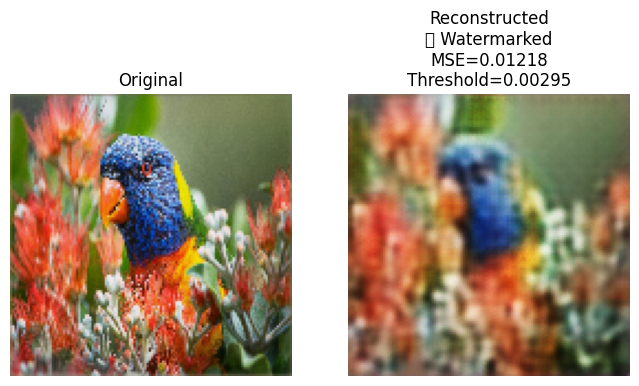

In [ ]:
# ==========================================================
# 🔍 Invisible Watermark Detection (Colab + Auto Threshold)
# ==========================================================
import torch, torch.nn as nn, torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import os, random, numpy as np, matplotlib.pyplot as plt
from google.colab import files

# -----------------------------
# Autoencoder (same as training)
# -----------------------------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,stride=2,padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# -----------------------------
# Dataset class (clean CelebA subset)
# -----------------------------
class CelebADataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

# -----------------------------
# Device + Model Load
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
model.load_state_dict(torch.load("models/autoencoder_clean_fast.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully on", device)

# -----------------------------
# Transforms
# -----------------------------
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

# -----------------------------
# Compute automatic threshold from clean validation subset
# -----------------------------
clean_dir = "./data/celeba/img_align_celeba"  # same clean folder used in training
dataset = CelebADataset(clean_dir, transform=transform)

subset_indices = random.sample(range(len(dataset)), min(300, len(dataset)))
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=16, shuffle=False)

print("\n🔧 Calculating clean validation losses for threshold...")
losses = []
with torch.no_grad():
    for imgs, _ in loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        mse_batch = torch.mean((recon - imgs) ** 2, dim=[1,2,3]).cpu().numpy()
        losses.extend(mse_batch)

losses = np.array(losses)
mean_loss = np.mean(losses)
std_loss = np.std(losses)
threshold = mean_loss + 2 * std_loss

print(f"📊 Mean MSE (clean): {mean_loss:.6f}")
print(f"📊 Std Deviation:   {std_loss:.6f}")
print(f"⚙️ Auto Threshold:   {threshold:.6f}")

# -----------------------------
# Upload image from device (Colab)
# -----------------------------
print("\n📤 Please upload an image from your device for watermark detection:")
uploaded = files.upload()

if not uploaded:
    print("❌ No file uploaded.")
    exit()

# Get first uploaded file
file_path = list(uploaded.keys())[0]
print(f"✅ File uploaded: {file_path}")

# -----------------------------
# Load and preprocess uploaded image
# -----------------------------
img = Image.open(file_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# -----------------------------
# Reconstruction + MSE
# -----------------------------
with torch.no_grad():
    recon = model(img_tensor)
mse_loss = nn.functional.mse_loss(recon, img_tensor).item()

# -----------------------------
# Decision
# -----------------------------
label = "🚫 Watermarked" if mse_loss > threshold else "✅ Clean"
print(f"\nReconstruction MSE: {mse_loss:.6f}")
print(f"Prediction: {label}")

# -----------------------------
# Visualization
# -----------------------------
recon_np = recon.cpu().squeeze().permute(1,2,0).numpy()
orig_np = img_tensor.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig_np)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(recon_np)
plt.title(f"Reconstructed\n{label}\nMSE={mse_loss:.5f}\nThreshold={threshold:.5f}")
plt.axis("off")

plt.show()


✅ Model loaded successfully on cuda

🔧 Calculating clean validation losses for threshold...
📊 Mean MSE (clean): 0.001389
📊 Std Deviation:   0.000825
⚙️ Auto Threshold:   0.003039

📤 Please upload one or more images for watermark detection:


Saving clean.jpg to clean (2).jpg
Saving foster-lake.jpg to foster-lake (2).jpg
Saving sample1_watermarked.png to sample1_watermarked (2).png
Saving sample3_watermarked.png to sample3_watermarked (2).png
Saving sample4_watermarked.png to sample4_watermarked (2).png
Saving test.jpg to test (2).jpg
Saving watermarked (1).png to watermarked (1) (2).png

🖼️ Processing file: clean (2).jpg
   Reconstruction MSE: 0.000843
   Prediction: ✅ Clean


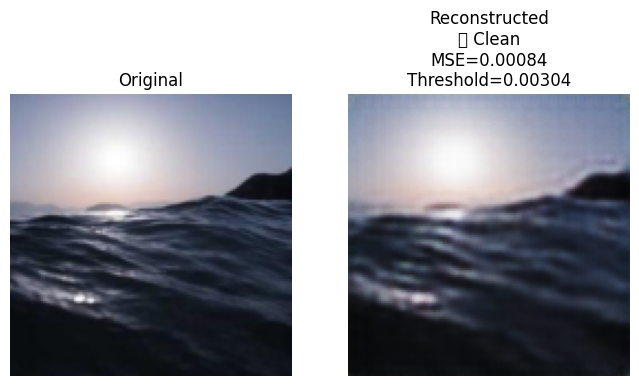


🖼️ Processing file: foster-lake (2).jpg
   Reconstruction MSE: 0.002487
   Prediction: ✅ Clean


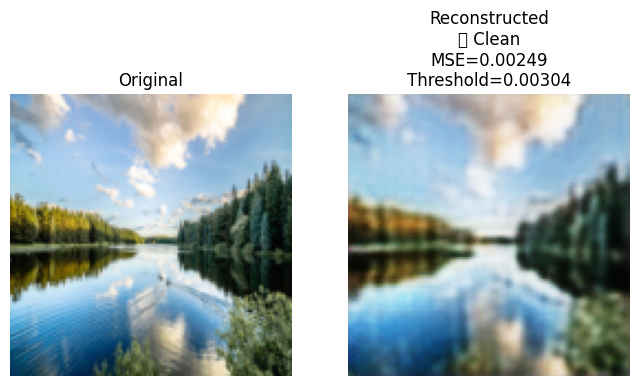


🖼️ Processing file: sample1_watermarked (2).png
   Reconstruction MSE: 0.010757
   Prediction: 🚫 Watermarked


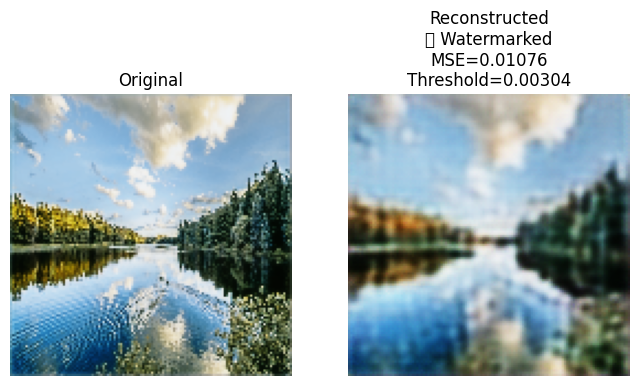


🖼️ Processing file: sample3_watermarked (2).png
   Reconstruction MSE: 0.005563
   Prediction: 🚫 Watermarked


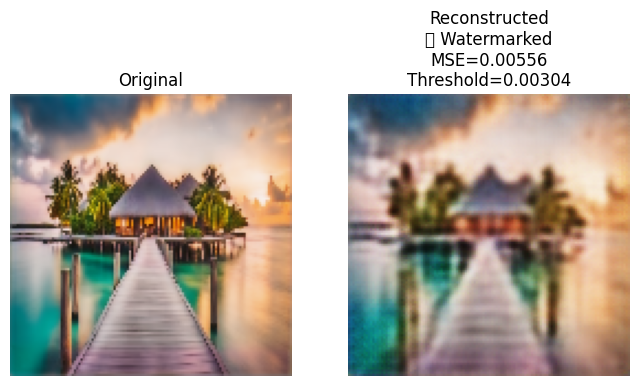


🖼️ Processing file: sample4_watermarked (2).png
   Reconstruction MSE: 0.007778
   Prediction: 🚫 Watermarked


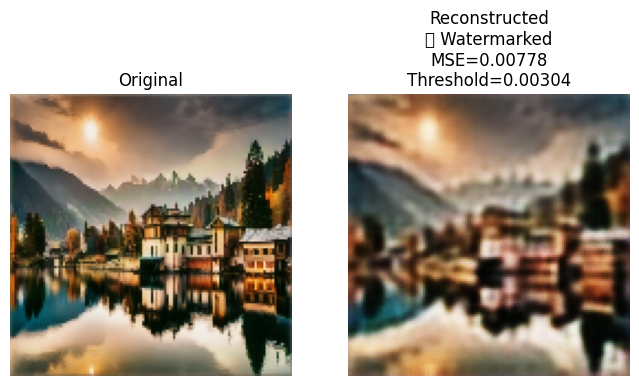


🖼️ Processing file: test (2).jpg
   Reconstruction MSE: 0.001535
   Prediction: ✅ Clean


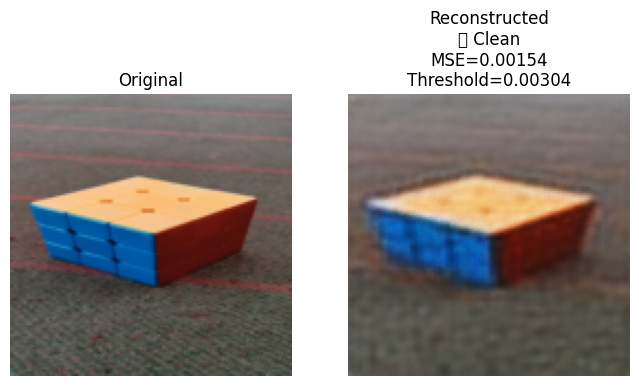


🖼️ Processing file: watermarked (1) (2).png
   Reconstruction MSE: 0.011838
   Prediction: 🚫 Watermarked


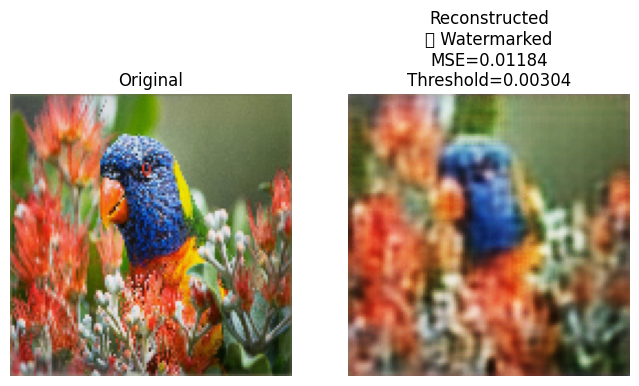

In [ ]:
# ==========================================================
# 🔍 Invisible Watermark Detection (Multi-Image, Auto Threshold)
# ==========================================================
import torch, torch.nn as nn, torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import os, random, numpy as np, matplotlib.pyplot as plt
from google.colab import files

# -----------------------------
# Autoencoder (same as training)
# -----------------------------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,stride=2,padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# -----------------------------
# Dataset class (clean CelebA subset)
# -----------------------------
class CelebADataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

# -----------------------------
# Device + Model Load
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
model.load_state_dict(torch.load("models/autoencoder_clean_fast.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully on", device)

# -----------------------------
# Transforms
# -----------------------------
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

# -----------------------------
# Compute automatic threshold from clean validation subset
# -----------------------------
clean_dir = "./data/celeba/img_align_celeba"  # same clean folder used in training
dataset = CelebADataset(clean_dir, transform=transform)

subset_indices = random.sample(range(len(dataset)), min(300, len(dataset)))
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=16, shuffle=False)

print("\n🔧 Calculating clean validation losses for threshold...")
losses = []
with torch.no_grad():
    for imgs, _ in loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        mse_batch = torch.mean((recon - imgs) ** 2, dim=[1,2,3]).cpu().numpy()
        losses.extend(mse_batch)

losses = np.array(losses)
mean_loss = np.mean(losses)
std_loss = np.std(losses)
threshold = mean_loss + 2 * std_loss

print(f"📊 Mean MSE (clean): {mean_loss:.6f}")
print(f"📊 Std Deviation:   {std_loss:.6f}")
print(f"⚙️ Auto Threshold:   {threshold:.6f}")

# -----------------------------
# Upload multiple images (Colab)
# -----------------------------
print("\n📤 Please upload one or more images for watermark detection:")
uploaded = files.upload()

if not uploaded:
    print("❌ No files uploaded.")
    raise SystemExit

# -----------------------------
# Process each uploaded image
# -----------------------------
for file_path in uploaded.keys():
    print(f"\n🖼️ Processing file: {file_path}")
    img = Image.open(file_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(img_tensor)

    mse_loss = nn.functional.mse_loss(recon, img_tensor).item()
    label = "🚫 Watermarked" if mse_loss > threshold else "✅ Clean"

    print(f"   Reconstruction MSE: {mse_loss:.6f}")
    print(f"   Prediction: {label}")

    # Visualization
    recon_np = recon.cpu().squeeze().permute(1,2,0).numpy()
    orig_np = img_tensor.cpu().squeeze().permute(1,2,0).numpy()

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(orig_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(recon_np)
    plt.title(f"Reconstructed\n{label}\nMSE={mse_loss:.5f}\nThreshold={threshold:.5f}")
    plt.axis("off")

    plt.show()


✅ Model loaded successfully on cuda

🔧 Calculating clean validation losses for threshold...
📊 Mean MSE (clean): 0.001829
📊 Std Deviation:   0.000835
⚙️ Auto Threshold:   0.003499

📤 Please upload one or more images for watermark detection:


Saving clean.jpg to clean (3).jpg
Saving cover.jpg to cover (1).jpg
Saving foster-lake.jpg to foster-lake (2).jpg
Saving test.jpg to test (2).jpg
Saving watermarked (3).png to watermarked (3) (1).png
Saving watermarked (4).png to watermarked (4) (3).png

🖼️ Processing file: clean (3).jpg
   Reconstruction MSE: 0.001147
   Prediction: ✅ Clean


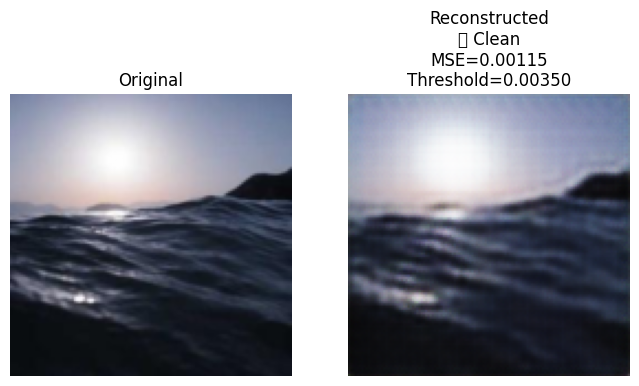


🖼️ Processing file: cover (1).jpg
   Reconstruction MSE: 0.007213
   Prediction: 🚫 Watermarked


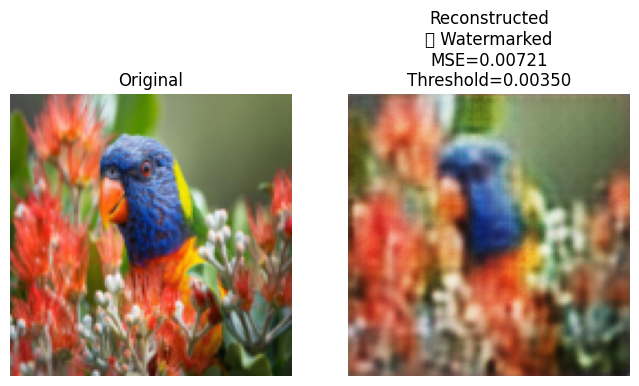


🖼️ Processing file: foster-lake (2).jpg
   Reconstruction MSE: 0.002888
   Prediction: ✅ Clean


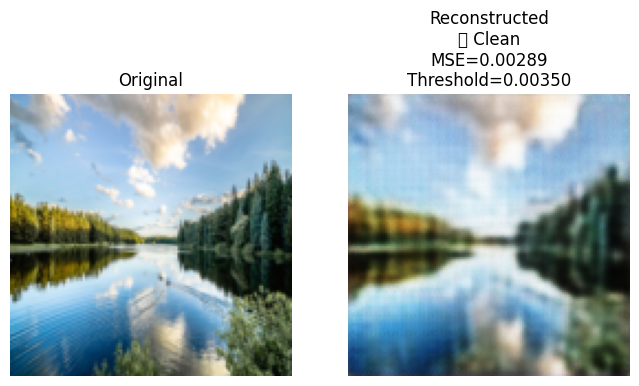


🖼️ Processing file: test (2).jpg
   Reconstruction MSE: 0.001903
   Prediction: ✅ Clean


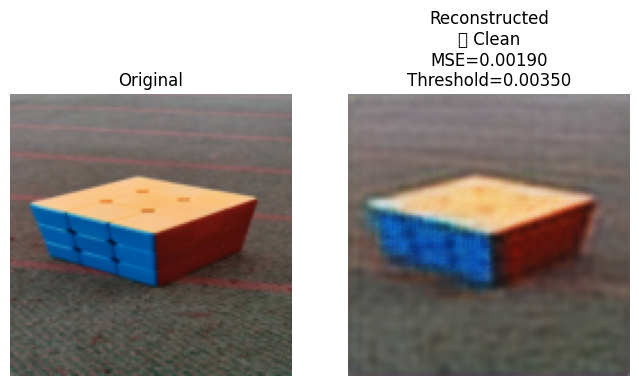


🖼️ Processing file: watermarked (3) (1).png
   Reconstruction MSE: 0.012185
   Prediction: 🚫 Watermarked


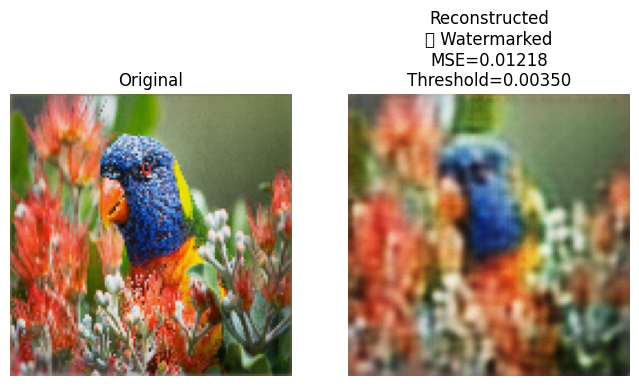


🖼️ Processing file: watermarked (4) (3).png
   Reconstruction MSE: 0.001579
   Prediction: ✅ Clean


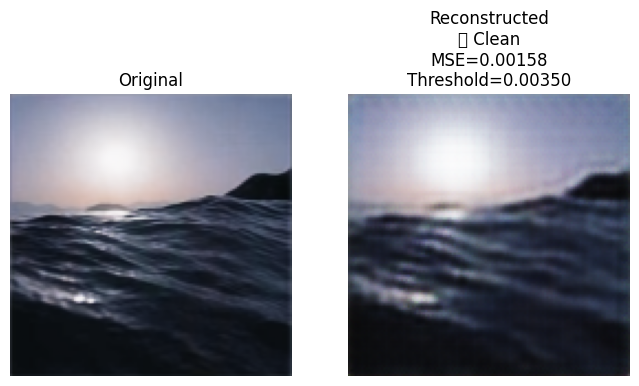

In [ ]:
# ==========================================================
# 🔍 Invisible Watermark Detection (Multi-Image, Auto Threshold)
# ==========================================================
import torch, torch.nn as nn, torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import os, random, numpy as np, matplotlib.pyplot as plt
from google.colab import files

# -----------------------------
# Autoencoder (same as training)
# -----------------------------
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(True),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(32,3,4,stride=2,padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# -----------------------------
# Dataset class (clean CelebA subset)
# -----------------------------
class CelebADataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

# -----------------------------
# Device + Model Load
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
model.load_state_dict(torch.load("models/autoencoder_clean_fast.pth", map_location=device))
model.eval()
print("✅ Model loaded successfully on", device)

# -----------------------------
# Transforms
# -----------------------------
transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

# -----------------------------
# Compute automatic threshold from clean validation subset
# -----------------------------
clean_dir = "./data/celeba/img_align_celeba"  # same clean folder used in training
dataset = CelebADataset(clean_dir, transform=transform)

subset_indices = random.sample(range(len(dataset)), min(300, len(dataset)))
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=16, shuffle=False)

print("\n🔧 Calculating clean validation losses for threshold...")
losses = []
with torch.no_grad():
    for imgs, _ in loader:
        imgs = imgs.to(device)
        recon = model(imgs)
        mse_batch = torch.mean((recon - imgs) ** 2, dim=[1,2,3]).cpu().numpy()
        losses.extend(mse_batch)

losses = np.array(losses)
mean_loss = np.mean(losses)
std_loss = np.std(losses)
threshold = mean_loss + 2 * std_loss

print(f"📊 Mean MSE (clean): {mean_loss:.6f}")
print(f"📊 Std Deviation:   {std_loss:.6f}")
print(f"⚙️ Auto Threshold:   {threshold:.6f}")

# -----------------------------
# Upload multiple images (Colab)
# -----------------------------
print("\n📤 Please upload one or more images for watermark detection:")
uploaded = files.upload()

if not uploaded:
    print("❌ No files uploaded.")
    raise SystemExit

# -----------------------------
# Process each uploaded image
# -----------------------------
for file_path in uploaded.keys():
    print(f"\n🖼️ Processing file: {file_path}")
    img = Image.open(file_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(img_tensor)

    mse_loss = nn.functional.mse_loss(recon, img_tensor).item()
    label = "🚫 Watermarked" if mse_loss > threshold else "✅ Clean"

    print(f"   Reconstruction MSE: {mse_loss:.6f}")
    print(f"   Prediction: {label}")

    # Visualization
    recon_np = recon.cpu().squeeze().permute(1,2,0).numpy()
    orig_np = img_tensor.cpu().squeeze().permute(1,2,0).numpy()

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(orig_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(recon_np)
    plt.title(f"Reconstructed\n{label}\nMSE={mse_loss:.5f}\nThreshold={threshold:.5f}")
    plt.axis("off")

    plt.show()
